In [16]:
import pandas as pd
import os
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance
import shap

import umap.umap_ as umap

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

FIGS_FOLDER = '../artifacts'
os.makedirs(FIGS_FOLDER, exist_ok=True)


save_path = 'classification_package'

In [17]:
file_path = os.path.join("..","data","processed_data.csv")

df = pd.read_csv(file_path)

X = df.drop(columns=['Class', 'WsRF', 'Latency', 'Best Practices', 'Response Time', 'Service Name_0', 'Service Name_1', 'Service Name_2', 'Service Name_3']) 
Y = df['Class']

In [18]:
df.groupby('Class')['Class'].count() / len(df) * 100

Class
1    11.263736
2    27.472527
3    32.967033
4    28.296703
Name: Class, dtype: float64

# Define baseline

In [19]:

baseline_model = LogisticRegression(random_state=42)

scalers=[StandardScaler(), MinMaxScaler()]

for scaler in scalers:
    
    print(f'=== Scaller: {scaler}====')
    X_scalled = scaler.fit_transform(X)
    X_scalled = pd.DataFrame(X_scalled, columns=X.columns)

    X_rest, X_test, Y_rest, Y_test = train_test_split(X_scalled,Y, test_size=0.15, random_state=42, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42, stratify=Y_rest)

    baseline_model.fit(X_train, Y_train)

    # 4. Predict on test set
    y_pred = baseline_model.predict(X_val)

    # 5. Evaluate performance
    print("Baseline Accuracy:", accuracy_score(Y_val, y_pred))
    print("\nClassification Report:\n", classification_report(Y_val, y_pred))


=== Scaller: StandardScaler()====
Baseline Accuracy: 0.8548387096774194

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.86      0.92         7
           2       0.79      0.88      0.83        17
           3       0.81      0.81      0.81        21
           4       0.94      0.88      0.91        17

    accuracy                           0.85        62
   macro avg       0.88      0.86      0.87        62
weighted avg       0.86      0.85      0.86        62

=== Scaller: MinMaxScaler()====
Baseline Accuracy: 0.8064516129032258

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.14      0.25         7
           2       0.67      0.82      0.74        17
           3       0.80      0.95      0.87        21
           4       1.00      0.88      0.94        17

    accuracy                           0.81        62
   macro avg       0.87      0.70      0.70    

StandardScaler gives better accuracy

- feature importance in baseline model

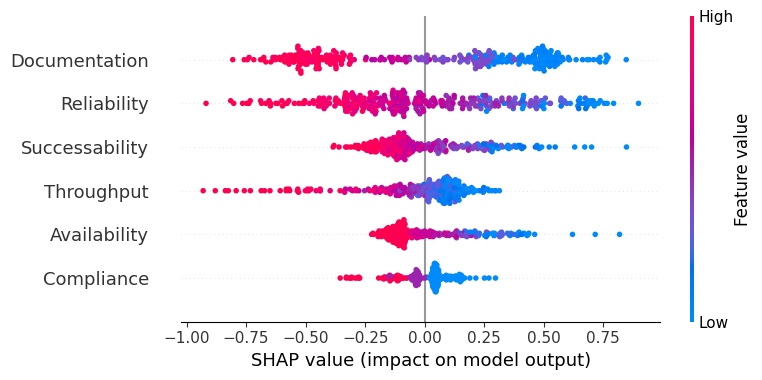

<Figure size 640x480 with 0 Axes>

In [20]:
scalers=StandardScaler()
X_scalled = scaler.fit_transform(X)
X_scalled=pd.DataFrame(X_scalled, columns = X.columns)

X_rest, X_test, Y_rest, Y_test = train_test_split(X_scalled,Y, test_size=0.15, random_state=42, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42, stratify = Y_rest)

baseline_model.fit(X_rest,Y_rest)
explainer = shap.Explainer(baseline_model.predict, X_rest)  
shap_values = explainer(X_rest)

shap.summary_plot(shap_values, X_rest)

plt.savefig( os.path.join(FIGS_FOLDER, 'classification_shap.png'))

Removing Response Time, Best Pratices and Latency can reduce overfitting risk; Improve model interpretability; Speed up training and inference.

[0.08640777 0.13042071 0.12071197 0.26472492 0.03462783 0.26472492]


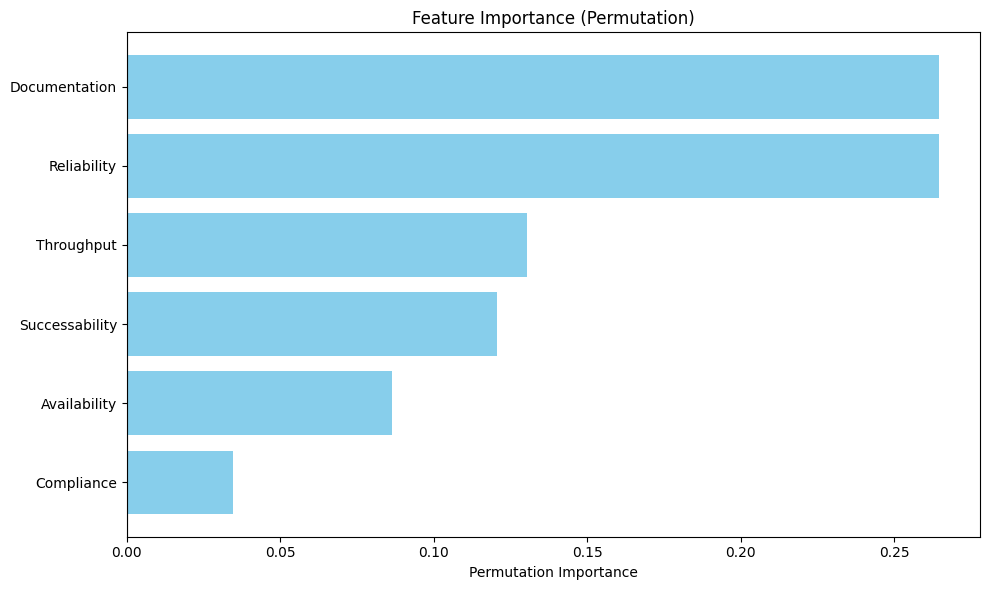

<Figure size 640x480 with 0 Axes>

In [21]:
result = permutation_importance(baseline_model, X_rest, Y_rest, n_repeats=10, random_state=42)
print(result.importances_mean)


# Feature names and importance values
importances = result.importances_mean
features = X_rest.columns

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df_sorted = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(FIGS_FOLDER, 'classification_permutation_importance.png'))

High permutation importance might come from interactions or leakage rather than true explanatory power.
Keeping them could lead to overfitting, especially if they represent identifiers rather than meaningful attributes.

- With dimensionality reduction

In [22]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scalled)

umap_X_rest, umap_X_test, umap_Y_rest, umap_Y_test = train_test_split(X_umap, Y, test_size=0.15, random_state=42, stratify = Y)
umap_X_train, umap_X_val, umap_Y_train, umap_Y_val = train_test_split(umap_X_rest, umap_Y_rest, test_size=0.2, random_state=42, stratify = umap_Y_rest)

baseline_model.fit(umap_X_train, umap_Y_train)

# Predict on test set
umap_y_pred = baseline_model.predict(umap_X_val)

# Evaluate performance
print("Baseline Accuracy:", accuracy_score(umap_Y_val, umap_y_pred))
print("\nClassification Report:\n", classification_report(umap_Y_val, umap_y_pred))

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Baseline Accuracy: 0.6290322580645161

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.50      0.76      0.60        17
           3       0.80      0.57      0.67        21
           4       0.67      0.82      0.74        17

    accuracy                           0.63        62
   macro avg       0.49      0.54      0.50        62
weighted avg       0.59      0.63      0.59        62



c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

When applying UMAP dimensionality reduction, baseline accuracy decreased so it is not useful.

In [23]:
models = {
    'lr': LogisticRegression(max_iter=1000, random_state=42, C=1.0),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(max_depth=2, random_state=42),
    'nb': GaussianNB(),
    'svm': svm.SVC(probability=True, kernel='rbf', C=1.0),  
    'knc': KNeighborsClassifier(n_neighbors=3),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, probability=True)
}

param_grids = {
    'lr': {
        'solver': ['lbfgs', 'liblinear']
    },
    'dt': {
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'rf': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'svm': {
        'gamma': ['scale', 'auto']
    },
    'knc': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'xgb': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}


In [ ]:
k_folds = KFold(n_splits = 5)

model_scores={}
cv_results = {}


for name, model in models.items():
    if name in param_grids:
                    
        search = RandomizedSearchCV(model, param_grids[name], cv=k_folds, scoring='accuracy', n_jobs=-1)
        
        if name =='xgb':
            search.fit(X_rest, Y_rest-1)
        else:
            search.fit(X_rest, Y_rest)

        best_score = search.best_score_
        best_model = search.best_estimator_
        print(f"{name}: Best Score={best_score:.4f}, Best Params={search.best_params_}")


        cv_results[name] = {
            "best_score": best_score,
            "best_params": search.best_params_,
            "cv_scores": list(search.cv_results_['mean_test_score'])
        }

    else:
        if name =='xgb':
            scores = cross_val_score(model, X_rest, Y_rest-1, cv=k_folds, scoring='accuracy')
            best_model = model.fit(X_rest, Y_rest-1)
        else:
            scores = cross_val_score(model, X_rest, Y_rest, cv=k_folds, scoring='accuracy')
            best_model = model.fit(X_rest, Y_rest)

        best_score = scores.mean()
        
        print(f"{name}: Score={best_score:.4f}")
        

        cv_results[name] = {
            "best_score": best_score,
            "cv_scores": list(scores)
        }

    
    model_scores[name] = (best_score, best_model)

# Select best model
best_model_name = max(model_scores, key=lambda k: model_scores[k][0])

best_model = model_scores[best_model_name][1]
print(f"\nBest model: {best_model_name} with score {model_scores[best_model_name][0]:.4f}")


metrics_path = os.path.join(save_path, "metrics")
os.makedirs(metrics_path, exist_ok=True)

cv_file = os.path.join(metrics_path,"cv_results.json")

with open(cv_file, "w") as f:
    json.dump(cv_results, f, indent=4)

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


lr: Best Score=0.7088, Best Params={'solver': 'lbfgs'}
dt: Best Score=0.6669, Best Params={'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
rf: Best Score=0.7479, Best Params={'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}
nb: Score=0.6603


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


svm: Best Score=0.7766, Best Params={'gamma': 'scale'}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


knc: Best Score=0.7766, Best Params={'weights': 'distance', 'n_neighbors': 9}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\november_tasks\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:21:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "probability", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


xgb: Best Score=0.7672, Best Params={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 1.0}

Best model: svm with score 0.7766


FileNotFoundError: [Errno 2] No such file or directory: 'classification_package\\metrics\\cv_results.json'

In [29]:
best_model.fit(X_rest, Y_rest)

y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)

test_accuracy = accuracy_score(Y_test, y_pred)
report_dict = classification_report(Y_test, y_pred, output_dict=True)

print('Best Model:', best_model_name)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(Y_test, y_pred))

# Prepare data for saving
test_metrics = {
    "best_model": best_model_name,
    "test_accuracy": test_accuracy,
    "classification_report": report_dict
}


metrics_file = os.path.join(save_path, "test_metrics.json")
with open(metrics_file, "w") as f:
    json.dump(test_metrics, f, indent=4)


Best Model: svm
Test Accuracy: 0.5818
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         6
           2       0.56      0.67      0.61        15
           3       0.50      0.61      0.55        18
           4       0.69      0.56      0.62        16

    accuracy                           0.58        55
   macro avg       0.69      0.54      0.57        55
weighted avg       0.63      0.58      0.58        55



In [ ]:
# model
model_name = best_model_name
joblib.dump(best_model, os.path.join(save_path, 'model.pkl'))

['classification_package\\model.pkl']

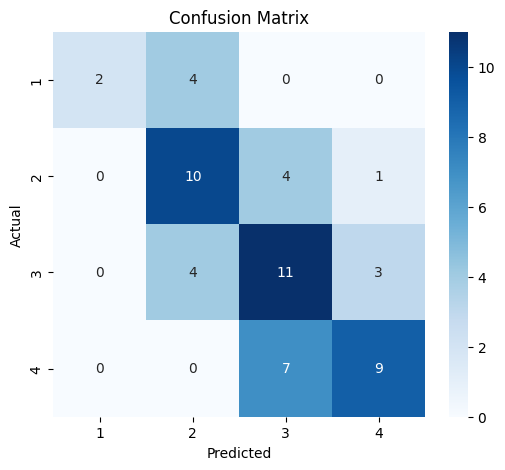

<Figure size 640x480 with 0 Axes>

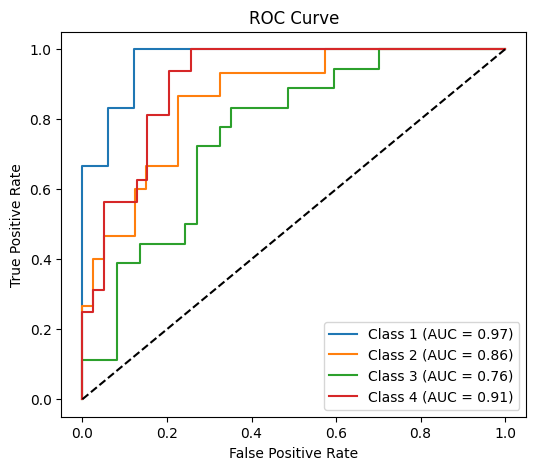

<Figure size 640x480 with 0 Axes>

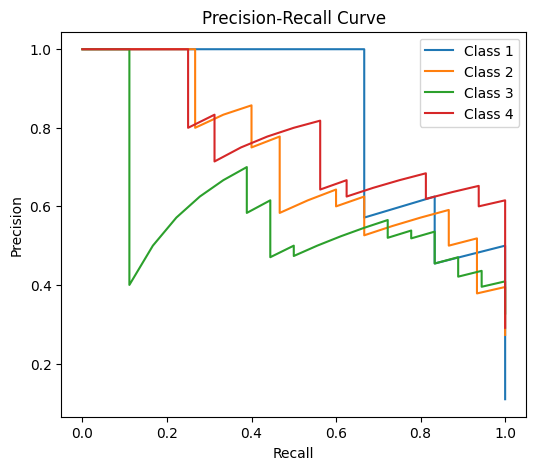

<Figure size 640x480 with 0 Axes>

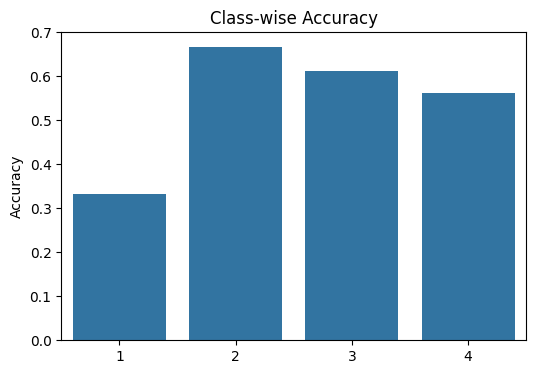

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)  # [1, 2, 3, 4]

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    plt.savefig(os.path.join(FIGS_FOLDER, 'classification_CM_8_11_1.png'))


def plot_roc_curve(y_true, y_score):
    classes = np.unique(y_true)  # [1, 2, 3, 4]

    plt.figure(figsize=(6, 5))
    
    for idx, cls in enumerate(classes):
        
        fpr, tpr, _ = roc_curve(y_true == cls, y_score[:, idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(FIGS_FOLDER, 'classification_roc_curve.png'))


def plot_precision_recall(y_true, y_score):

    classes = np.unique(y_true)  # [1, 2, 3, 4]
    
    plt.figure(figsize=(6, 5))

    for idx, cls in enumerate(classes):  # idx = 0..3, cls = 1..4
    
        precision, recall, _ = precision_recall_curve(y_true == cls, y_score[:, idx])
        plt.plot(recall, precision, label=f'Class {cls}')
    
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(FIGS_FOLDER, 'classification_precision_recall.png'))


def plot_class_accuracy(y_true, y_pred):
    classes = np.unique(y_true)  # [1, 2, 3, 4]
    
    accuracies = []
    for cls in classes:
        cls_idx = (y_true == cls)
        acc = np.mean(y_pred[cls_idx] == cls)
        accuracies.append(acc)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=classes, y=accuracies)
    plt.title('Class-wise Accuracy')
    plt.ylabel('Accuracy')
    plt.savefig(os.path.join(FIGS_FOLDER, 'classification_accuracy.png'))


plot_confusion_matrix(Y_test, y_pred)
plot_roc_curve(Y_test, y_score)
plot_precision_recall(Y_test, y_score)
plot_class_accuracy(Y_test, y_pred)

Most errors occur between Class 0 and Class 1, suggesting these two classes might have overlapping features.

All classes have excellent discrimination ability (AUC > 0.9). Class 0 performs best in terms of ROC.

In [ ]:

# Metrics
metrics = {
    "accuracy": accuracy_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred, average='weighted'),
    "recall": recall_score(Y_test, y_pred, average='weighted'),
    "f1_score": f1_score(Y_test, y_pred, average='weighted')
}

with open(os.path.join(save_path, 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)
pd.DataFrame([metrics]).to_csv(os.path.join(save_path, 'metrics.csv'), index=False)


# model card
data_info = {"source": "qws1/data.csv", "size": len(df)}

with open(os.path.join(save_path, 'model_card.md'), 'w') as f:
    f.write(f"""
        # Model Card: {model_name}

        ## Data
        Source: {data_info.get('source')}
        Size: {data_info.get('size')}

        ## Features
        {', '.join(X_test.columns)}

        ## Metrics
        {json.dumps(metrics, indent=4)}
        """)

print(f"Model package saved at: {save_path}")

NameError: name 'accuracy_score' is not defined